## Wake County - Restaurant Food Inspections Analysis

**Authors:** Shyamal Anadkat, Hearsch Jariwala, Christine Park

**Objective:** Develop a predictive model for Wake County officials in identifying restaurants at high risk for having a critical inspection violation so that officials can better allocate their resources for inspection. 

### Resources
 1. [Restaurants in Wake County Data Info](https://www.arcgis.com/home/item.html?id=124c2187da8c41c59bde04fa67eb2872)
 2. [Wake County Open Data](https://data-wake.opendata.arcgis.com/search?tags=restaurants)
 3. [Food Inspection Violations Data Info](https://data.wakegov.com/datasets/Wake::food-inspection-violations/about)
 4. [Wake County Yelp Initiative](https://ash.harvard.edu/news/wake-county-yelp-initiative)
 5. [Yelp LIVES data](https://www.yelp.com/healthscores/feeds)

## Downloading and Importing Relevant Packages and Libraries

Note: We're sourcing and pre-processing all the data in other notebooks. We have saved the pre-processed data in csv files so we can load them into dataframes in our main file here. If you do want to source them from here, you're free to do so.

In [37]:
#install packages if not already installed
#!pip install tpot
#!pip install scikit-learn --upgrade
#!pip install feature_engine
#!pip install optuna
#!pip install lightgbm
#!pip install mlxtend
#!pip install shap
#!pip3 install PyQt5
#!pip install autoviz
#!pip install dtale

In [112]:
# import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json

# import sklearn and tpot modules for preprocessing, pipelines, and modeling 
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest,f_regression, mutual_info_regression, f_classif, RFECV
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error, accuracy_score, recall_score, plot_roc_curve, classification_report, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, PrecisionRecallDisplay, ConfusionMatrixDisplay, confusion_matrix
from tpot import TPOTClassifier
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, cross_val_score
from pandas_profiling import ProfileReport
from mlxtend.plotting import plot_decision_regions
import xgboost
import matplotlib
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier

#importing dtale foe EDA
import dtale

# import light gbm
import lightgbm
from lightgbm import LGBMClassifier

# import optuna for hyperparameter tuning 
import optuna
from optuna.samplers import TPESampler

# import shap for interpretability experimentation
import shap

# import outlier trimmer 
from feature_engine.outliers import OutlierTrimmer


import warnings
warnings.filterwarnings(action='ignore')
plt.style.use('seaborn')
%matplotlib inline

## Fetching Dataset #1: Restaurant Data 

In [113]:
restaurantsdf = pd.read_csv('preprocessed_restaurants.csv')
print("The restaurant dataframe has {} rows and {} columns".format(restaurantsdf.shape[0], restaurantsdf.shape[1]))
restaurantsdf.head()

The restaurant dataframe has 2380 rows and 12 columns


,OBJECTID,HSISID,NAME,ADDRESS1,CITY,POSTALCODE,PHONENUMBER,RESTAURANTOPENDATE,PERMITID,X,Y,GEOCODESTATUS
0,1924822,4092016155,DAILY PLANET CAFE,11 W JONES ST,RALEIGH,27601,1.919708e+10,2012-04-12,2,-78.639431,35.782205,M
1,1924823,4092016161,HIBACHI 88,3416 POOLE RD,RALEIGH,27610,1.919231e+10,2012-04-18,4,-78.579533,35.767246,M
2,1924824,4092017180,BOND BROTHERS BEER COMPANY,202 E CEDAR ST,CARY,27511,1.919459e+10,2016-03-11,5,-78.778021,35.787986,M
3,1924825,4092018352,Prime Barbeque,403 KNIGHTDALE STATION RUN,KNIGHTDALE,27545,1.919374e+10,2020-04-22,6,-78.473566,35.797225,M
4,1924828,4092017192,STARBUCKS #19453,185 GRAND HILL PL,HOLLY SPRINGS,27540,1.919557e+10,2016-04-05,16,-78.849481,35.662665,M


## Fetching Dataset #2: Restaurant Inspection Data

In [114]:
inspectionsdf = pd.read_csv('preprocessed_inspections.csv')
print("The restaurant inspection dataframe has {} rows and {} columns".format(inspectionsdf.shape[0], inspectionsdf.shape[1]))
inspectionsdf.head()

The restaurant inspection dataframe has 36657 rows and 6 columns


,OBJECTID,HSISID,SCORE,DATE,TYPE,INSPECTOR
0,22332274,4092017542,94.5,2017-04-07,Inspection,Anne-Kathrin Bartoli
1,22332275,4092017542,92.0,2017-11-08,Inspection,Laura McNeill
2,22332276,4092017542,95.0,2018-03-23,Inspection,Laura McNeill
3,22332277,4092017542,93.5,2018-09-07,Inspection,Laura McNeill
4,22332278,4092017542,93.0,2019-04-04,Inspection,Joanne Rutkofske


## Fetching Dataset #3: Restaurant Inspection Violation Data

In [115]:
violationsdf = pd.read_csv('preprocessed_violations.csv')
print("The restaurant inspection violation dataframe has {} rows and {} columns".format(violationsdf.shape[0], violationsdf.shape[1]))
violationsdf.head()

The restaurant inspection violation dataframe has 265671 rows and 11 columns


,OBJECTID,HSISID,INSPECTDATE,CATEGORY,CRITICAL,SEVERITY,SHORTDESC,INSPECTEDBY,POINTVALUE,OBSERVATIONTYPE,VIOLATIONTYPE
0,190682112,4092016699,2017-03-24,Approved Source,No,NaN,Food obtained from approved source,Angela Myers,0.0,IN,NaN
1,190682241,4092030492,2021-06-14,Approved Source,No,NaN,Food obtained from approved source,David Adcock,1.0,OUT,NaN
2,190682242,4092017453,2017-10-18,Approved Source,No,NaN,Food obtained from approved source,Maria Powell,0.0,OUT,VR
3,190682243,4092015754,2017-11-15,Approved Source,No,NaN,Food obtained from approved source,Maria Powell,0.0,OUT,CDI
4,190682250,4092110015,2018-04-17,Approved Source,No,NaN,Food received at proper temperature,Laura McNeill,1.0,OUT,CDI


## Fetching Dataset #4: Yelp Review Data

In [116]:
yelpdatadf = pd.read_csv('preprocessed_yelpdata.csv')
print("The yelp review dataframe has {} rows and {} columns".format(yelpdatadf.shape[0], yelpdatadf.shape[1]))
display(yelpdatadf.head())

The yelp review dataframe has 2144 rows and 7 columns


,name,review_count,rating,price,phone,display_phone,category_title
0,Peace China,63,3.5,1,19196769968,(919) 676-9968,chinese
1,Asian Cafe,7,3.0,2,19196769968,(919) 676-9968,chinese
2,Northside Bistro & Cocktails,23,4.5,-1,19198905225,(919) 890-5225,american (new)
3,The Daily Planet Cafe,89,4.0,2,19197078060,(919) 707-8060,cafes
4,Hibachi 88,46,3.5,1,19192311688,(919) 231-1688,japanese


## Fetching Dataset #5: Daily Weather Data

In [117]:
weatherdatadf = pd.read_csv('preprocessed_weatherdata.csv')
print("The weather dataframe has {} rows and {} columns".format(weatherdatadf.shape[0], weatherdatadf.shape[1]))
weatherdatadf.head()

The weather dataframe has 2141 rows and 2 columns


,date,TAVG
0,2016-01-01,49.0
1,2016-01-02,43.0
2,2016-01-03,40.0
3,2016-01-04,38.0
4,2016-01-05,29.0


## Fetching Dataset #6: Daily Police Incident
- Using this as proxy for crime data

In [118]:
crimedatadf = pd.read_csv('preprocessed_crimedata.csv')
crimeagg = pd.read_csv('feature_crimedata.csv')
print("The crime dataframe has {} rows and {} columns".format(crimedatadf.shape[0], crimedatadf.shape[1]))
print("The crime dataframe has the following categories:")
print(crimedatadf['crime_category'].value_counts())
display(crimedatadf.head())
display(crimeagg.head())

The crime dataframe has 289228 rows and 10 columns
The crime dataframe has the following categories:
MISCELLANEOUS                     68556
ASSAULT                           36628
LARCENY                           29565
DRUGS                             22376
FRAUD                             18543
VANDALISM                         18270
LARCENY FROM MV                   18086
ALL OTHER OFFENSES                13161
DRUG VIOLATIONS                    9043
BURGLARY/RESIDENTIAL               7951
WEAPONS VIOLATION                  7907
HUMANE                             7329
TRAFFIC                            6572
MV THEFT                           5660
SEX OFFENSES                       3650
ROBBERY                            3312
DISORDERLY CONDUCT                 2592
BURGLARY/COMMERCIAL                2546
STOLEN PROPERTY                    2020
UNAUTHORIZED MOTOR VEHICLE USE     1419
EMBEZZLEMENT                        840
LIQUOR LAW VIOLATIONS               839
JUVENILE           

,OBJECTID,crime_category,crime_code,crime_description,city,reported_date,reported_year,reported_month,reported_day,reported_dayofwk
0,12001,MISCELLANEOUS,81H,Miscellaneous/Missing Person (18 & over),RALEIGH,2017-01-15,2017,1,14,Saturday
1,12002,MISCELLANEOUS,81A,Miscellaneous/All Other Non-Offenses,RALEIGH,2017-07-29,2017,7,29,Saturday
2,12003,MISCELLANEOUS,81F,Miscellaneous/Mental Commitment,RALEIGH,2016-03-07,2016,3,6,Sunday
3,12006,MISCELLANEOUS,81A,Miscellaneous/All Other Non-Offenses,RALEIGH,2016-07-12,2016,7,12,Tuesday
4,12007,MISCELLANEOUS,81K,Miscellaneous/Overdose Death,RALEIGH,2017-04-10,2017,4,10,Monday


,reported_date,crime_count,frequent_crime_code
0,2016-01-01,140,25E
1,2016-01-02,138,81A
2,2016-01-03,143,25E
3,2016-01-04,117,35H
4,2016-01-05,110,81A


## Setting Up the Outcome Variable for the Risk Prediction Model

**1. Using the restaurant inspection scores**

We plan to potentially translate the restaurant inspection scores (numerical) to the Yelp LIVES grading scheme (ordinal A, B, C, D, F).

Note: LIVES is an open data standard which allows municipalities to publish restaurant inspection information to Yelp.


In [119]:
legend = pd.read_csv('YELP(LIVES)/legend.csv')
display(legend)

,minimum_score,maximum_score,description
0,90,100,A
1,80,89,B
2,70,79,C
3,60,69,D
4,0,59,F


In [120]:
def get_score_grade(legend_df, score):
    legend_dict = score_legend.to_dict('records') # creating a dictionary of the scoring categories
    
    for d in legend_dict:
        if score >= d['minimum_score'] and score <= d['maximum_score']:
                return d['description']

**2. Using "Critical/Not Critical" binary inspection violation classification scheme**

In [121]:
def aggregate_violations(rest_violation):

    rest_violation['CRITICAL'].fillna("No", inplace=True) # filling in missing values as "No"
    rest_violation['CRITICAL'] = rest_violation['CRITICAL'].apply(lambda x: (x=='Yes')) # converting "Yes/No" to "True/False"
    
    agg_critical = rest_violation.groupby(['HSISID','INSPECTDATE'],as_index=False)['CRITICAL'].agg('sum') # adding up the number of critical violations that individual restuaurants had per inspection date
    agg_critical['HAS CRITICAL'] = agg_critical['CRITICAL'] > 2 # defining a variable that flags whether there was 2 or more critical violation for a restaurant per inspection date
    
    return agg_critical


agg_viol = aggregate_violations(violationsdf.copy())
print(agg_viol['HAS CRITICAL'].value_counts())
agg_viol

False    28011
True     14352
Name: HAS CRITICAL, dtype: int64


,HSISID,INSPECTDATE,CRITICAL,HAS CRITICAL
0,0,2020-12-21,2,False
1,0,2021-03-16,1,False
2,4092010018,2016-03-17,5,True
3,4092010018,2017-05-11,2,False
4,4092010018,2017-08-07,4,True
...,...,...,...,...
42358,4092300292,2020-09-30,1,False
42359,4092300292,2021-06-30,1,False
42360,4092300293,2021-05-10,0,False
42361,4092300293,2021-09-28,1,False


## Merging All Dataset to Create Final Dataframe with Relevant Features from Each Dataset

In [122]:
# Create copy of original DataFrames
rest_df = restaurantsdf.copy()
rest_inspect = inspectionsdf.copy()
rest_violation = violationsdf.copy()
yelp_df = yelpdatadf.copy()
temp_df = weatherdatadf.copy()
crime_df = crimedatadf.copy()
score_legend = legend.copy()

In [165]:
pd.set_option('display.max_columns', None) #to see all columns

def create_feature_table(rest_inspect, rest_df, rest_violation, temp_df, score_legend, crime_df, yelp_df, crime_agg):
    # merging the inspectionsdf & restaurantsdf based on HSISID (which is primary key for identifying unique restaurants)
    firstmerge_df = rest_inspect.merge(rest_df, how='left', on=['HSISID'])
    
    firstmerge_df.drop(['OBJECTID_x', 'OBJECTID_y'], axis=1, inplace=True) # dropping irrelevant columns
    
    # merging firstmerge with weather data based on date
    secondmerge_df = firstmerge_df.merge(temp_df, how='left', left_on='DATE', right_on='date')
    
    secondmerge_df.drop(['date'], axis=1, inplace=True) # dropping irrelevant columns
    
    # merging secondmerge with yelp data based on name
    secondmerge_df["NAME"] = secondmerge_df["NAME"].str.lower()
    yelp_df["name"] = yelp_df["name"].str.lower()
    thirdmerge_df = secondmerge_df.merge(yelp_df, left_on="NAME", right_on="name", how="left")
    
    thirdmerge_df.drop_duplicates(['DATE', 'HSISID'], inplace=True) # dropping duplicates
    thirdmerge_df.drop(['display_phone', 'name', 'PHONENUMBER'], axis=1, inplace=True) # dropping irrelevant columns
    thirdmerge_df.dropna(subset=['review_count'], inplace=True) # dropping any missing values from the number of reviews column
    
    # second merge the two datasets
    crime_agg['reported_date'] = pd.to_datetime(crime_agg['reported_date'])
    fourthmerge_df = thirdmerge_df.copy()
    fourthmerge_df['DATE'] = pd.to_datetime(fourthmerge_df['DATE'])
    fourthmerge_df = fourthmerge_df.merge(crime_agg, how='left', left_on='DATE', right_on='reported_date')
    
    fourthmerge_df = fourthmerge_df.drop_duplicates(subset=['SCORE', 'DATE', 'NAME']) # dropping duplicates

    # applying the Yelp LIVES grading scheme function defined above to the restaurant inspection score (potential outcome variable 1)
    fourthmerge_df['SCORE GRADE'] = fourthmerge_df['SCORE'].apply(lambda s: get_score_grade(score_legend, s))

    # merging fourthmerge with critical inspection violation data (potential outcome variable 2)
    agg_critical = aggregate_violations(rest_violation)
    fifthmerge = fourthmerge_df.copy()
    agg_critical['INSPECTDATE'] = pd.to_datetime(agg_critical['INSPECTDATE'])
    fifthmerge = fifthmerge.merge(agg_critical, how='inner', left_on=['DATE', 'HSISID'], right_on=['INSPECTDATE', 'HSISID'])
    
    fifthmerge.drop(['SCORE','SCORE GRADE'], axis=1, inplace=True) #dropping irrelevant columns
    #print(finale['HAS CRITICAL'].value_counts())

    # finalizing all the features
    # including zipcode as feature
    final_features= fifthmerge.copy()
    final_features['POSTALCODE'] = final_features['POSTALCODE'].str.split('-').str[0]
    
    # including days open since inspection
    final_features['RESTAURANTOPENDATE'] = pd.to_datetime(final_features['RESTAURANTOPENDATE'])
    final_features['DAYS OPEN SINCE INSPECTION'] = (pd.to_datetime(final_features['DATE']) - pd.to_datetime(final_features['RESTAURANTOPENDATE'])).dt.days
    
    final_features = final_features.drop(['DATE','phone','ADDRESS1','GEOCODESTATUS','RESTAURANTOPENDATE','reported_date'], axis=1) # dropping irrelevant columns
    
    #cleaning remaining features 
    final_features.CITY = final_features.CITY.str.lower()
    
    final_features['price'] = final_features['price'].fillna(final_features['price'].mode()[0])
    
    # rename X and Y to lon and lat
    final_features.rename(columns={'X': 'lon', 'Y' :'lat'}, inplace=True)
    
    return final_features
    
final_features_df = create_feature_table(rest_inspect.copy(), rest_df.copy(), 
                                         rest_violation.copy(), temp_df.copy(), score_legend.copy(), crime_df.copy(), yelp_df.copy(), crimeagg.copy())
print("The final features dataframe has {} rows and {} columns".format(final_features_df.shape[0], final_features_df.shape[1]))
final_features_df.head()

The final features dataframe has 6906 rows and 20 columns


,HSISID,TYPE,INSPECTOR,NAME,CITY,POSTALCODE,PERMITID,lon,lat,TAVG,review_count,rating,price,category_title,crime_count,frequent_crime_code,INSPECTDATE,CRITICAL,HAS CRITICAL,DAYS OPEN SINCE INSPECTION
0,4092017542,Inspection,Anne-Kathrin Bartoli,american deli,raleigh,27610,33.0,-78.61376,35.754388,53.0,10.0,3.5,1.0,chicken wings,133,81A,2017-04-07,4,True,37
1,4092017542,Inspection,Laura McNeill,american deli,raleigh,27610,33.0,-78.61376,35.754388,45.0,10.0,3.5,1.0,chicken wings,116,81A,2017-11-08,4,True,252
2,4092017542,Inspection,Laura McNeill,american deli,raleigh,27610,33.0,-78.61376,35.754388,42.0,10.0,3.5,1.0,chicken wings,134,81A,2018-03-23,3,True,387
3,4092017542,Inspection,Laura McNeill,american deli,raleigh,27610,33.0,-78.61376,35.754388,81.0,10.0,3.5,1.0,chicken wings,138,81A,2018-09-07,2,False,555
4,4092017542,Inspection,Joanne Rutkofske,american deli,raleigh,27610,33.0,-78.61376,35.754388,60.0,10.0,3.5,1.0,chicken wings,147,81A,2019-04-04,2,False,764


## Handling Outliers

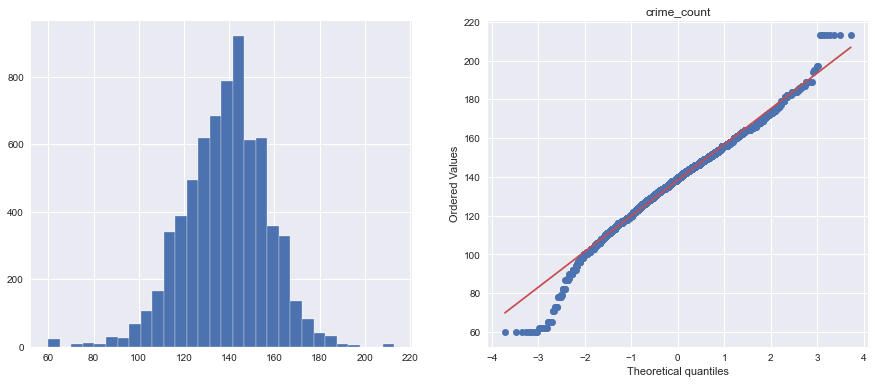

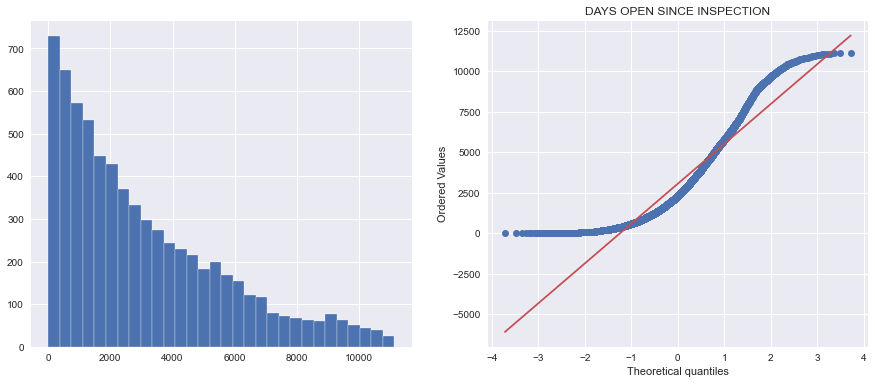

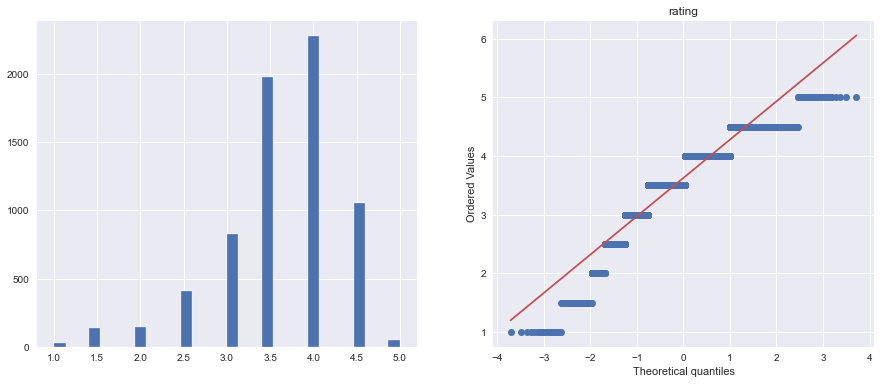

In [166]:
def diag_normal_var(df, variable):
      plt.figure(figsize=(15,6))
      plt.subplot(1, 2, 1)
      df[variable].hist(bins=30)

      plt.subplot(1, 2, 2)
      stats.probplot(df[variable], dist='norm', plot = plt)
      plt.title(variable)
      plt.show()
        
numerical_features = ['crime_count', 'DAYS OPEN SINCE INSPECTION', 'rating']
                      
for i in numerical_features:
      diag_normal_var(final_features_df, i)

### Attempt to remove outliers with a gaussian approximation (3 sd)

In [167]:
## Remove outliers with a gaussian approximation (3 sd)
def remove_outliners(df):
    # set up the capper
    capper = OutlierTrimmer(capping_method='gaussian', tail='both', fold=1, variables=numerical_features)

    # fit the capper
    capper.fit(df)

    # transform the data
    df = capper.transform(df)

    capper.right_tail_caps_
    
remove_outliners(final_features_df)
print(final_features_df.shape)
final_features_df.head()

(6906, 20)


,HSISID,TYPE,INSPECTOR,NAME,CITY,POSTALCODE,PERMITID,lon,lat,TAVG,review_count,rating,price,category_title,crime_count,frequent_crime_code,INSPECTDATE,CRITICAL,HAS CRITICAL,DAYS OPEN SINCE INSPECTION
0,4092017542,Inspection,Anne-Kathrin Bartoli,american deli,raleigh,27610,33.0,-78.61376,35.754388,53.0,10.0,3.5,1.0,chicken wings,133,81A,2017-04-07,4,True,37
1,4092017542,Inspection,Laura McNeill,american deli,raleigh,27610,33.0,-78.61376,35.754388,45.0,10.0,3.5,1.0,chicken wings,116,81A,2017-11-08,4,True,252
2,4092017542,Inspection,Laura McNeill,american deli,raleigh,27610,33.0,-78.61376,35.754388,42.0,10.0,3.5,1.0,chicken wings,134,81A,2018-03-23,3,True,387
3,4092017542,Inspection,Laura McNeill,american deli,raleigh,27610,33.0,-78.61376,35.754388,81.0,10.0,3.5,1.0,chicken wings,138,81A,2018-09-07,2,False,555
4,4092017542,Inspection,Joanne Rutkofske,american deli,raleigh,27610,33.0,-78.61376,35.754388,60.0,10.0,3.5,1.0,chicken wings,147,81A,2019-04-04,2,False,764


## Using Pandas Profiling for EDA

In [77]:
#profile = ProfileReport(final_features_df, title="Pandas Profiling Report", explorative=True)
#profile

In [170]:
# Use dtale
d = dtale.show(final_features_df)
d.open_browser()

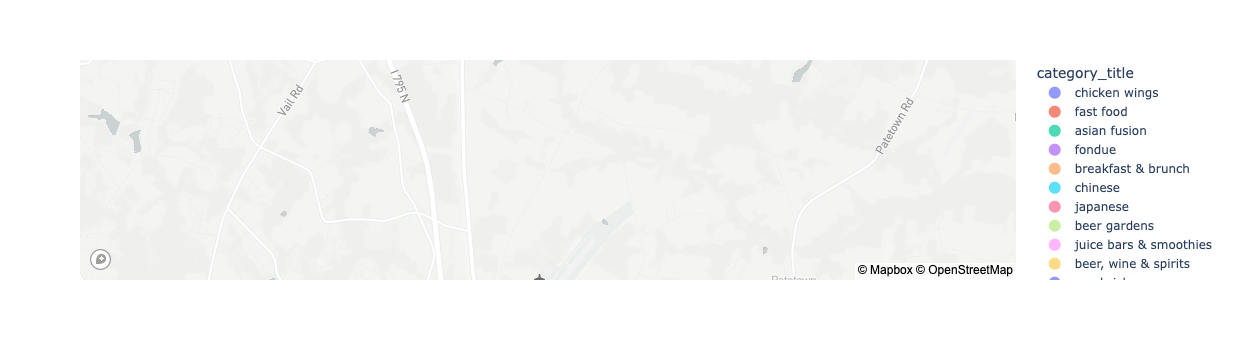

In [179]:
import plotly.express as px
mbtoken = 'pk.eyJ1IjoiaGVhcnNjaCIsImEiOiJja3Z6eGdzbGgwc2lmMm5ycDI2ZHE2bjhwIn0.H7rY4NZjvHX3ihaZwCFaXw'
px.set_mapbox_access_token(mbtoken)
fig = px.scatter_mapbox(final_features_df, lat="lat", lon="lon", size="CRITICAL", color='category_title',
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=20, zoom=12)
fig.show()

Note: We decided to drop the "Score"/"Score Grade" outcome variables because of significant class imbalance (skewed heavily to A and B with very few C and no D. 

**Hence we will use the "Has Critical" (T/F) variable as our final outcome variable.**

## Spltting Data into Training and Test Sets

In [126]:
# function for splitting data into training and test sets
def split_data(df):
    X = df.drop(['CRITICAL', 'HAS CRITICAL', 'HSISID'],axis=1)
    y = df['HAS CRITICAL']
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0, shuffle=True)
    return X_train,X_test,y_train,y_test

print(final_features_df['HAS CRITICAL'].value_counts(dropna=False))
X_train, X_test, y_train, y_test = split_data(final_features_df)
print(X_train.shape, X_test.shape)

False    3813
True     3093
Name: HAS CRITICAL, dtype: int64
(5524, 17) (1382, 17)


## Encoding the Features in Training and Test Sets

**Numerical features:** <br /> 
    Standardize each feature

**Categorical features:** <br /> 
    One-hot encode values for each feature

**Ordinal features:** <br /> 
    Ordinal encode  values for each feature

In [127]:
# defining numerical, categorical, and ordinal features for encoding the training set
numeric_features = ['review_count', 'crime_count', 'TAVG', 'DAYS OPEN SINCE INSPECTION', 'X', 'Y']
categorical_features = ['TYPE', 'INSPECTOR', 'CITY', 'category_title', 'frequent_crime_code']
ordinal_features = ['NAME', 'INSPECTDATE', 'POSTALCODE', 'rating', 'price']

In [128]:
# function for encoding the training set
def encode_traindf(X, numeric_features, categorical_features, ordinal_features):
    X = X.copy()
    # numerical features
    scaler_num = StandardScaler() # defining scaler for numerical features 
    X[numeric_features] = scaler_num.fit_transform(X[numeric_features]) #scaling the numerical features
    
    # categorical features
    for col in categorical_features:
        X[categorical_features] = X[categorical_features].astype(str)

    onehot_enc = OneHotEncoder(handle_unknown='ignore') # defining encoder
    onehot_enc.fit(X[categorical_features]) # fitting encoder 
    colnames = list(onehot_enc.get_feature_names(input_features=categorical_features))  # getting the names of the new columns created
    
    onehot_vals = onehot_enc.transform(X[categorical_features]).toarray() # transforming the data
    enc_df = pd.DataFrame(onehot_vals,columns=colnames,index=X.index) # putting the transformed data into dataframe
    X = pd.concat([X,enc_df],axis=1).drop(categorical_features,axis=1) # adding onehot columns back onto original dataframe and dropping the original columns

    # ordinal features
    ord_enc =  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1) # defining encoder
    X[ordinal_features] = ord_enc.fit_transform(X[ordinal_features]) # fitting encoder

    scaler_ord = StandardScaler() # defining scaler for ordinal features
    X[ordinal_features] = scaler_ord.fit_transform(X[ordinal_features]) # scaling the ordinal features
    
    return X, ord_enc, scaler_num, scaler_ord, onehot_enc

X_train, ord_enc, scaler_num, scaler_ord, onehot_enc = encode_traindf(X_train.copy(), numeric_features, categorical_features, ordinal_features)
print("The training set has {} rows and {} columns".format(X_train.shape[0], X_train.shape[1]))
display(X_train.head())

The training set has 5524 rows and 195 columns


,NAME,POSTALCODE,PERMITID,X,Y,TAVG,review_count,rating,price,crime_count,INSPECTDATE,DAYS OPEN SINCE INSPECTION,TYPE_Inspection,TYPE_Re-Inspection,INSPECTOR_Andrea Anover,INSPECTOR_Angela Jacobs,INSPECTOR_Angela Myers,INSPECTOR_Anne-Kathrin Bartoli,INSPECTOR_Ashley Whittington,INSPECTOR_Brittny Thomas,INSPECTOR_Caroline Suggs,INSPECTOR_Chris Askew,INSPECTOR_Christopher Walker,INSPECTOR_Christy Klaus,INSPECTOR_Cristofer LeClair,INSPECTOR_Daryl Beasley,INSPECTOR_David Adcock,INSPECTOR_Dimitri Parker,INSPECTOR_Dipatrimarki Farkas,INSPECTOR_Elizabeth Jackson,INSPECTOR_Ginger Johnson,INSPECTOR_Greta Welch,INSPECTOR_Jackson Hooton,INSPECTOR_James Smith,INSPECTOR_Jamie Phelps,INSPECTOR_Jason Dunn,INSPECTOR_Jennifer Brown,INSPECTOR_Jennifer Edwards,INSPECTOR_Jessica Andrews,INSPECTOR_Joanne Rutkofske,INSPECTOR_Johanna Hill,INSPECTOR_John Wulffert,INSPECTOR_Jordan Jernigan,INSPECTOR_Joshua Volkan,INSPECTOR_Kaitlyn Yow,INSPECTOR_Karla Crowder,INSPECTOR_Kendra Wiggins,INSPECTOR_Laura McNeill,INSPECTOR_Lauren Harden,INSPECTOR_Lisa McCoy,INSPECTOR_Loc Nguyen,INSPECTOR_Lucy Schrum,INSPECTOR_Maria Powell,INSPECTOR_Marion Wearing,INSPECTOR_Meghan Scott,INSPECTOR_Melodee Johnson,INSPECTOR_Michael Robinson,INSPECTOR_Naterra McQueen,INSPECTOR_Nicole Millard,INSPECTOR_Nikia Lawrence,INSPECTOR_Pamela Scott,INSPECTOR_Patricia Sabby,INSPECTOR_Samatha Sparano,INSPECTOR_Sarah Thompson,INSPECTOR_Shakera Robbins,INSPECTOR_Shannon Flynn,INSPECTOR_Thomas Jumalon,INSPECTOR_Ursula Gadomski,INSPECTOR_Zachary Carter,CITY_apex,CITY_apex,CITY_cary,CITY_cary,CITY_fuquay varina,CITY_fuquay-varina,CITY_garner,CITY_holly springs,CITY_knightdale,CITY_morrisville,CITY_raleigh,CITY_raleigh,CITY_rolesville,CITY_wake forest,CITY_wendell,CITY_zebulon,category_title_american (new),category_title_american (traditional),category_title_amusement parks,category_title_arcades,category_title_asian fusion,category_title_bagels,category_title_bakeries,category_title_barbeque,category_title_bars,category_title_beer bar,category_title_beer gardens,"category_title_beer, wine & spirits",category_title_bowling,category_title_brazilian,category_title_breakfast & brunch,category_title_breweries,category_title_bubble tea,category_title_burgers,category_title_butcher,category_title_cafes,category_title_cajun/creole,category_title_cantonese,category_title_caribbean,category_title_chicken wings,category_title_chinese,category_title_churches,category_title_cinema,category_title_cocktail bars,category_title_coffee & tea,category_title_comfort food,category_title_convenience stores,category_title_country clubs,category_title_creperies,category_title_cuban,category_title_delis,category_title_desserts,category_title_dim sum,category_title_diners,category_title_dominican,category_title_fast food,category_title_filipino,category_title_fondue,category_title_gas stations,category_title_golf,category_title_greek,category_title_grocery,category_title_hawaiian,category_title_himalayan/nepalese,category_title_hotels,category_title_ice cream & frozen yogurt,category_title_indian,category_title_italian,category_title_japanese,category_title_juice bars & smoothies,category_title_kebab,category_title_korean,category_title_laotian,category_title_latin american,category_title_malaysian,category_title_mediterranean,category_title_mexican,category_title_middle eastern,category_title_mini golf,category_title_mongolian,category_title_noodles,category_title_organic stores,category_title_pakistani,category_title_persian/iranian,category_title_peruvian,category_title_pizza,category_title_poke,category_title_portuguese,category_title_pubs,category_title_ramen,category_title_restaurants,category_title_salad,category_title_salvadoran,category_title_sandwiches,category_title_seafood,category_title_skating rinks,category_title_social clubs,category_title_southern,category_title_sports bars,category_title_steakhouses,category_title_sushi bars,category_title_szechuan,category_title_tacos,category_title_taiwanese,category_t

In [129]:
# function for encoding the test set

def encode_testdf(X, ord_enc, scaler_num, scaler_ord, onehot_enc, numeric_features, categorical_features, ordinal_features):

    # numerical features
    X[numeric_features] = scaler_num.fit_transform(X[numeric_features]) #scaling the numerical features
    
    # categorical features
    for col in categorical_features:
        X[categorical_features] = X[categorical_features].astype(str)
    
    onehot_enc.transform(X[categorical_features]) # fitting encoder 
    colnames = list(onehot_enc.get_feature_names(input_features=categorical_features))  # getting the names of the new columns created
            
    onehot_vals = onehot_enc.transform(X[categorical_features]).toarray() # transforming the data
    enc_df = pd.DataFrame(onehot_vals,columns=colnames,index=X.index) # putting the transformed data into dataframe
    X = pd.concat([X,enc_df],axis=1).drop(categorical_features,axis=1) # adding onehot columns back onto original dataframe and dropping the original col

    # ordinal features
    X[ordinal_features] = ord_enc.transform(X[ordinal_features]) # fitting encoder
    X[ordinal_features] = scaler_ord.transform(X[ordinal_features]) # scaling the ordinal features
    
    return X

X_test = encode_testdf(X_test.copy(), ord_enc, scaler_num, scaler_ord, onehot_enc, numeric_features, categorical_features, ordinal_features)
print("The test set has {} rows and {} columns".format(X_test.shape[0], X_test.shape[1]))
display(X_test.head())

The test set has 1382 rows and 195 columns


,NAME,POSTALCODE,PERMITID,X,Y,TAVG,review_count,rating,price,crime_count,INSPECTDATE,DAYS OPEN SINCE INSPECTION,TYPE_Inspection,TYPE_Re-Inspection,INSPECTOR_Andrea Anover,INSPECTOR_Angela Jacobs,INSPECTOR_Angela Myers,INSPECTOR_Anne-Kathrin Bartoli,INSPECTOR_Ashley Whittington,INSPECTOR_Brittny Thomas,INSPECTOR_Caroline Suggs,INSPECTOR_Chris Askew,INSPECTOR_Christopher Walker,INSPECTOR_Christy Klaus,INSPECTOR_Cristofer LeClair,INSPECTOR_Daryl Beasley,INSPECTOR_David Adcock,INSPECTOR_Dimitri Parker,INSPECTOR_Dipatrimarki Farkas,INSPECTOR_Elizabeth Jackson,INSPECTOR_Ginger Johnson,INSPECTOR_Greta Welch,INSPECTOR_Jackson Hooton,INSPECTOR_James Smith,INSPECTOR_Jamie Phelps,INSPECTOR_Jason Dunn,INSPECTOR_Jennifer Brown,INSPECTOR_Jennifer Edwards,INSPECTOR_Jessica Andrews,INSPECTOR_Joanne Rutkofske,INSPECTOR_Johanna Hill,INSPECTOR_John Wulffert,INSPECTOR_Jordan Jernigan,INSPECTOR_Joshua Volkan,INSPECTOR_Kaitlyn Yow,INSPECTOR_Karla Crowder,INSPECTOR_Kendra Wiggins,INSPECTOR_Laura McNeill,INSPECTOR_Lauren Harden,INSPECTOR_Lisa McCoy,INSPECTOR_Loc Nguyen,INSPECTOR_Lucy Schrum,INSPECTOR_Maria Powell,INSPECTOR_Marion Wearing,INSPECTOR_Meghan Scott,INSPECTOR_Melodee Johnson,INSPECTOR_Michael Robinson,INSPECTOR_Naterra McQueen,INSPECTOR_Nicole Millard,INSPECTOR_Nikia Lawrence,INSPECTOR_Pamela Scott,INSPECTOR_Patricia Sabby,INSPECTOR_Samatha Sparano,INSPECTOR_Sarah Thompson,INSPECTOR_Shakera Robbins,INSPECTOR_Shannon Flynn,INSPECTOR_Thomas Jumalon,INSPECTOR_Ursula Gadomski,INSPECTOR_Zachary Carter,CITY_apex,CITY_apex,CITY_cary,CITY_cary,CITY_fuquay varina,CITY_fuquay-varina,CITY_garner,CITY_holly springs,CITY_knightdale,CITY_morrisville,CITY_raleigh,CITY_raleigh,CITY_rolesville,CITY_wake forest,CITY_wendell,CITY_zebulon,category_title_american (new),category_title_american (traditional),category_title_amusement parks,category_title_arcades,category_title_asian fusion,category_title_bagels,category_title_bakeries,category_title_barbeque,category_title_bars,category_title_beer bar,category_title_beer gardens,"category_title_beer, wine & spirits",category_title_bowling,category_title_brazilian,category_title_breakfast & brunch,category_title_breweries,category_title_bubble tea,category_title_burgers,category_title_butcher,category_title_cafes,category_title_cajun/creole,category_title_cantonese,category_title_caribbean,category_title_chicken wings,category_title_chinese,category_title_churches,category_title_cinema,category_title_cocktail bars,category_title_coffee & tea,category_title_comfort food,category_title_convenience stores,category_title_country clubs,category_title_creperies,category_title_cuban,category_title_delis,category_title_desserts,category_title_dim sum,category_title_diners,category_title_dominican,category_title_fast food,category_title_filipino,category_title_fondue,category_title_gas stations,category_title_golf,category_title_greek,category_title_grocery,category_title_hawaiian,category_title_himalayan/nepalese,category_title_hotels,category_title_ice cream & frozen yogurt,category_title_indian,category_title_italian,category_title_japanese,category_title_juice bars & smoothies,category_title_kebab,category_title_korean,category_title_laotian,category_title_latin american,category_title_malaysian,category_title_mediterranean,category_title_mexican,category_title_middle eastern,category_title_mini golf,category_title_mongolian,category_title_noodles,category_title_organic stores,category_title_pakistani,category_title_persian/iranian,category_title_peruvian,category_title_pizza,category_title_poke,category_title_portuguese,category_title_pubs,category_title_ramen,category_title_restaurants,category_title_salad,category_title_salvadoran,category_title_sandwiches,category_title_seafood,category_title_skating rinks,category_title_social clubs,category_title_southern,category_title_sports bars,category_title_steakhouses,category_title_sushi bars,category_title_szechuan,category_title_tacos,category_title_taiwanese,category_t

## Feature Selection Using Univariate Analysis

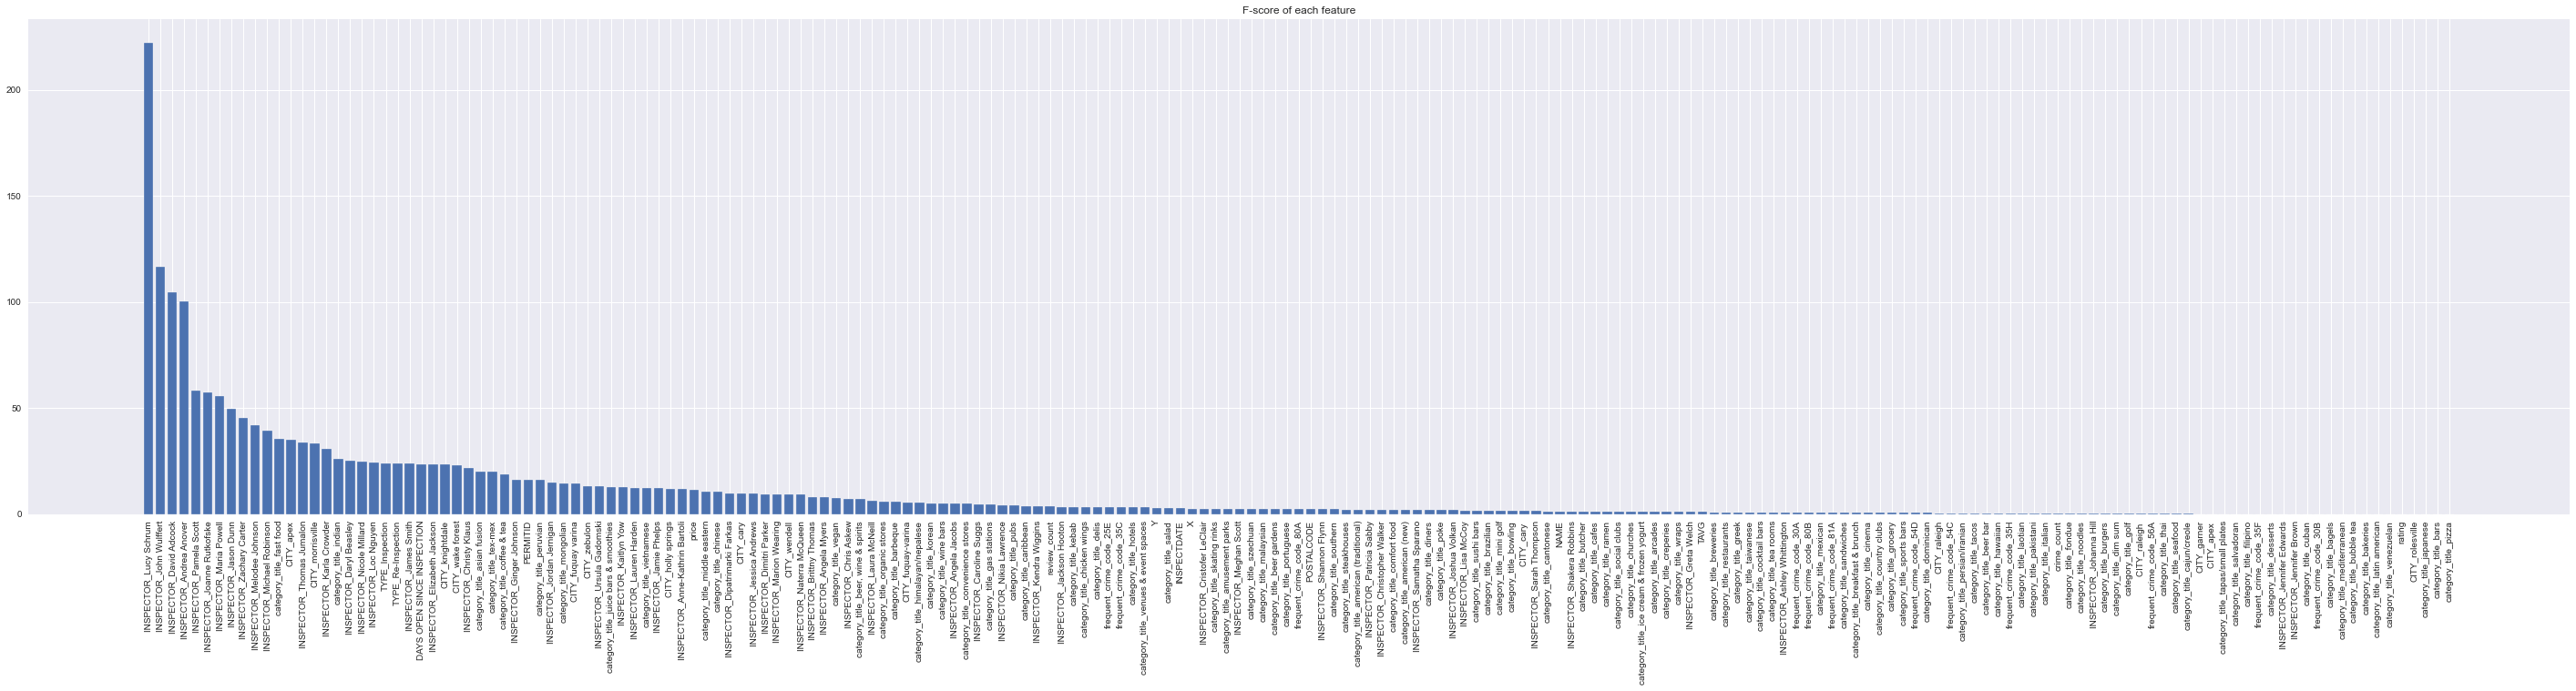

,Feature,F-Score
51,INSPECTOR_Lucy Schrum,222.154921
41,INSPECTOR_John Wulffert,116.548087
26,INSPECTOR_David Adcock,104.551903
14,INSPECTOR_Andrea Anover,100.295728
60,INSPECTOR_Pamela Scott,58.212701
39,INSPECTOR_Joanne Rutkofske,57.253666
52,INSPECTOR_Maria Powell,55.710080
35,INSPECTOR_Jason Dunn,49.699165
68,INSPECTOR_Zachary Carter,45.320434
55,INSPECTOR_Melodee Johnson,41.880315


In [130]:
def univariate_feature_selection(X_train, y_train):   
    # Evaluate features using ANOVA (score_func = f_classif)
    ftest = SelectKBest(score_func=f_classif, k='all')
    ftest.fit(X_train,y_train)
    f_scores = pd.DataFrame(ftest.scores_)
    dfcolumns = pd.DataFrame(X_train.columns)
    f_scores = pd.concat([dfcolumns,f_scores], axis=1)
    f_scores.columns = ['Feature','F-Score']  
    f_scores = f_scores.sort_values(by='F-Score', ascending=False)

    # Plot scores
    plt.figure(figsize=(50,10))
    plt.bar(x=f_scores['Feature'],height=f_scores['F-Score'])
    plt.xticks(rotation=90)
    plt.title('F-score of each feature')
    plt.show()
    display(f_scores.head(20)) # TODO: create bar chart
    
univariate_feature_selection(X_train, y_train)

## Feature Importance using Tree-based classifers

In [131]:
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)

print("Feature Importance:\n")
for name, importance in zip(X_train.columns, np.sort(rf_clf.feature_importances_)[::-1]):
    print("{} -- {:.2f}".format(name, importance))

Feature Importance:

NAME -- 0.10
POSTALCODE -- 0.09
PERMITID -- 0.08
X -- 0.08
Y -- 0.05
TAVG -- 0.05
review_count -- 0.04
rating -- 0.04
price -- 0.04
crime_count -- 0.03
INSPECTDATE -- 0.03
DAYS OPEN SINCE INSPECTION -- 0.02
TYPE_Inspection -- 0.01
TYPE_Re-Inspection -- 0.01
INSPECTOR_Andrea Anover -- 0.01
INSPECTOR_Angela Jacobs -- 0.01
INSPECTOR_Angela Myers -- 0.01
INSPECTOR_Anne-Kathrin Bartoli -- 0.01
INSPECTOR_Ashley Whittington -- 0.01
INSPECTOR_Brittny Thomas -- 0.01
INSPECTOR_Caroline Suggs -- 0.01
INSPECTOR_Chris Askew -- 0.01
INSPECTOR_Christopher Walker -- 0.01
INSPECTOR_Christy Klaus -- 0.01
INSPECTOR_Cristofer LeClair -- 0.01
INSPECTOR_Daryl Beasley -- 0.01
INSPECTOR_David Adcock -- 0.01
INSPECTOR_Dimitri Parker -- 0.01
INSPECTOR_Dipatrimarki Farkas -- 0.01
INSPECTOR_Elizabeth Jackson -- 0.01
INSPECTOR_Ginger Johnson -- 0.00
INSPECTOR_Greta Welch -- 0.00
INSPECTOR_Jackson Hooton -- 0.00
INSPECTOR_James Smith -- 0.00
INSPECTOR_Jamie Phelps -- 0.00
INSPECTOR_Jason Dunn -

**This method score features using a Tree-Based Classifiers. The higher the score more the feature is important to predict our target feature:**

[2.78995689e-02 2.04374634e-02 2.82595722e-02 2.72738042e-02
 2.82678447e-02 7.67632136e-02 2.68695139e-02 2.32015511e-02
 1.75775504e-02 7.63914842e-02 8.36487300e-02 8.28771598e-02
 2.72587974e-03 3.29460355e-03 1.53207835e-02 2.63450303e-03
 3.84390649e-03 2.44851117e-03 2.85657975e-05 3.14318969e-03
 2.44690795e-03 1.29698407e-03 7.13166918e-04 5.12517924e-03
 1.28006147e-03 4.67334567e-03 1.38238378e-02 1.65101431e-03
 1.90350853e-03 4.41778200e-03 3.81181024e-03 1.10447191e-03
 3.24239534e-03 3.90211011e-03 2.71247726e-03 7.95186642e-03
 4.21340748e-04 8.35293937e-04 1.84957574e-03 9.60466391e-03
 1.55620469e-03 1.63964238e-02 2.44785312e-03 3.64477221e-03
 1.37728788e-03 6.33958662e-03 3.05417527e-04 4.81391527e-03
 4.01000916e-03 1.70855640e-03 5.12168501e-03 3.37695557e-02
 1.05347104e-02 3.12874378e-03 2.70760018e-03 5.83776638e-03
 5.75615783e-03 4.46400602e-03 4.18652754e-03 8.07463809e-04
 8.56592725e-03 2.56662428e-03 1.67346214e-03 3.51022531e-03
 1.43182954e-03 1.455229

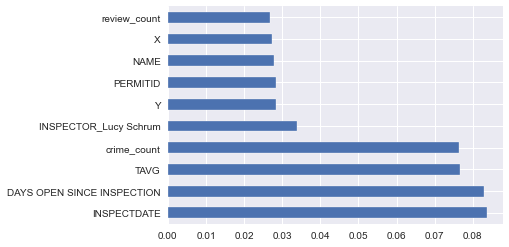

In [132]:
#Fit the model
model = ExtraTreesClassifier()
model.fit(X_train,y_train)
print(model.feature_importances_)
#plot graph of feature importances
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

## Using the TPOT Classifier to Find the Optimal Model

In [133]:
tpot = TPOTClassifier(verbosity=2, max_time_mins=2, max_eval_time_mins=0.04, population_size=40, scoring='f1')
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))

Optimization Progress:   0%|          | 0/40 [00:00<?, ?pipeline/s]


2.02 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: GaussianNB(input_matrix)
0.6723646723646723


**We obtained the following results from trying out various models:**

1. **KNeighborsClassifier**(input_matrix, n_neighbors=78, p=2, weights=uniform) <br /> 
F1 score = 0.9177903436276642

2. **KNeighborsClassifier**(RobustScaler(input_matrix), n_neighbors=24, p=2, weights=distance) <br />
F1 score = 0.9171075837742504

3. **DecisionTreeClassifier**(SelectPercentile(input_matrix, percentile=98), criterion=gini, max_depth=4, min_samples_leaf=10, min_samples_split=7) <br />
F1 score = 0.8553639846743295

4. **LogisticRegression**(SelectPercentile(MinMaxScaler(input_matrix), percentile=31), C=15.0, dual=False, penalty=l2) <br />
F1 score = 0.8545016077170418

5. **DecisionTreeClassifier(input_matrix, criterion=entropy, max_depth=6, min_samples_leaf=11, min_samples_split=13)** <br />
F1 score = 0.9174475680499777

6. **LinearSVC(input_matrix, C=5.0, dual=False, loss=squared_hinge, penalty=l1, tol=0.1)** <br />
F1 score = 0.9186830622768742

# Training, Testing, and Evaluation with the Final Model

**1. Hyperparameter Tuning**

In [135]:
def objective(trial):
    # instantiating scaler
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust'])

    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()
                
    # tuning estimator algorithm
    n_neighbors = trial.suggest_int("n_neighbors", 1, 30)
    weights = trial.suggest_categorical("weights", ['uniform', 'distance'])
    metric = trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski'])
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)
        
    # making a pipeline
    pipeline = make_pipeline(scaler, knn)

    # cross-validating the features reduced by dimensionality reduction methods
    kfold = StratifiedKFold(n_splits=10)
    score = cross_val_score(pipeline, X_train, y_train, scoring='f1', cv=kfold)
    score = score.mean()
    return score

sampler = TPESampler(seed=42) # creating a seed for the sampler for reproducibility
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=20)

[I 2021-11-14 19:14:04,373] A new study created in memory with name: no-name-5dbff3c4-2cb0-45bd-8538-5ebe7787a0b2
[I 2021-11-14 19:14:15,946] Trial 0 finished with value: 0.6356462620863197 and parameters: {'scalers': 'standard', 'n_neighbors': 18, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 0 with value: 0.6356462620863197.
[I 2021-11-14 19:14:17,422] Trial 1 finished with value: 0.5957424328675203 and parameters: {'scalers': 'robust', 'n_neighbors': 25, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 0 with value: 0.6356462620863197.
[I 2021-11-14 19:14:28,140] Trial 2 finished with value: 0.6270704031894616 and parameters: {'scalers': 'robust', 'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 0 with value: 0.6356462620863197.
[I 2021-11-14 19:14:38,991] Trial 3 finished with value: 0.653162703997228 and parameters: {'scalers': 'standard', 'n_neighbors': 19, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 3 with va

In [140]:
# obtaining the best parameters
study.best_trial.params

{'scalers': 'minmax',
 'n_neighbors': 12,
 'weights': 'distance',
 'metric': 'manhattan'}

**2. Model Development**

In [147]:
# instantiating scaler based on the best parameters
scaler = StandardScaler()
if study.best_trial.params['scalers'] == "minmax":
    scaler = MinMaxScaler()
elif study.best_trial.params['scalers'] == "standard":
    scaler = StandardScaler()
else:
    scaler = RobustScaler()

# creating a KNN model with the optimal scaler and best parameters  
knn_model = Pipeline([ ('scale', scaler),
                      ('knn', KNeighborsClassifier(n_neighbors=study.best_trial.params['n_neighbors'], weights=study.best_trial.params['weights'], metric=study.best_trial.params['metric']))])

# using KNN as our final model of choice
knn_model.fit(X_train, y_train)
knn_preds = knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_preds)
print('Accuracy:',knn_accuracy)
print('F1 Score:',f1_score(y_test, knn_preds))

print(classification_report(y_test, knn_preds))

Accuracy: 0.6931982633863966
F1 Score: 0.6454849498327759
              precision    recall  f1-score   support

       False       0.72      0.74      0.73       778
        True       0.65      0.64      0.65       604

    accuracy                           0.69      1382
   macro avg       0.69      0.69      0.69      1382
weighted avg       0.69      0.69      0.69      1382



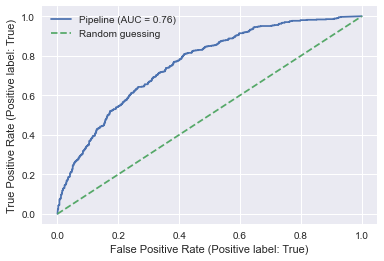

In [148]:
# Plot ROC
plot_roc_curve(knn_model, X_test, y_test)
# Add a line to show the curve for random guessing
plt.plot([0,1],[0,1],linestyle='--',label='Random guessing')
plt.legend()
plt.show()

**2.1. Train on the entire dataset**

In [143]:
X_full = pd.concat([X_train, X_test],ignore_index=True)
y_full = pd.concat([y_train, y_test],ignore_index=True)
X_full.shape, y_full.shape

# using KNN as our final model of choice
knn_model.fit(X_full, y_full)
knn_preds = knn_model.predict(X_full)
knn_accuracy = accuracy_score(y_full, knn_preds)
print('Accuracy:',knn_accuracy)
print('F1 Score:',f1_score(y_full, knn_preds))

Accuracy: 1.0
F1 Score: 1.0


**3. Model interpretability Using SHAP**

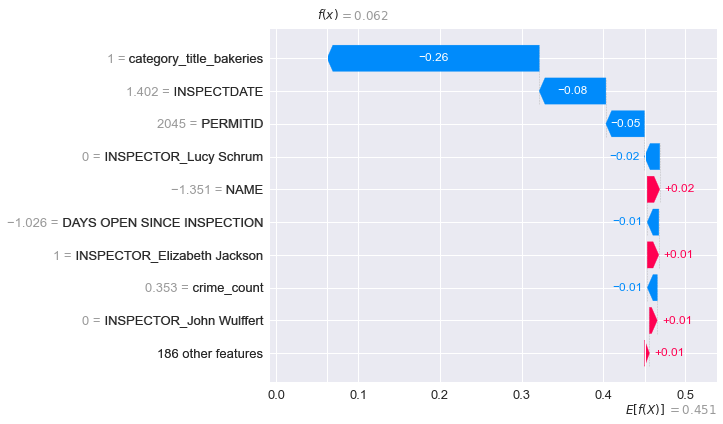

In [142]:
# fast C++ implementations are supported for XGBoost, LightGBM, CatBoost, scikit-learn and pyspark tree models:
# training an XGBoost model
model = xgboost.XGBRegressor()
model.fit(X_train, y_train)

# explaining the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

# visualizing the first prediction's explanation
shap.plots.waterfall(shap_values[0])
plt.show()